#1. Setup


In [1]:
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt
import cv2

import time
import os

from PIL import Image

from tqdm import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread, imsave
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage


torch.manual_seed(1)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#2. Data Setup

In [ ]:
cd /content/drive/MyDrive/data/

/content/drive/MyDrive/data


In [ ]:
!unzip '/content/drive/My Drive/data/1-D_horizontal dogs.zip' -d '/root/datasets'

Archive:  /content/drive/My Drive/data/1-D_horizontal dogs.zip
   creating: /root/datasets/1-D_horizontal dogs/
  inflating: /root/datasets/__MACOSX/._1-D_horizontal dogs  
   creating: /root/datasets/1-D_horizontal dogs/Schnauzer/
  inflating: /root/datasets/1-D_horizontal dogs/.DS_Store  
  inflating: /root/datasets/__MACOSX/1-D_horizontal dogs/._.DS_Store  
   creating: /root/datasets/1-D_horizontal dogs/French Bulldog/
  inflating: /root/datasets/__MACOSX/1-D_horizontal dogs/._French Bulldog  
   creating: /root/datasets/1-D_horizontal dogs/Chihuahua/
  inflating: /root/datasets/__MACOSX/1-D_horizontal dogs/._Chihuahua  
   creating: /root/datasets/1-D_horizontal dogs/Shiba Inu/
   creating: /root/datasets/1-D_horizontal dogs/Beagle/
  inflating: /root/datasets/__MACOSX/1-D_horizontal dogs/._Beagle  
   creating: /root/datasets/1-D_horizontal dogs/Labrador Retriever/
  inflating: /root/datasets/__MACOSX/1-D_horizontal dogs/._Labrador Retriever  
   creating: /root/datasets/1-D_hori

In [ ]:
# define training and test data directories
main_dir = '/root/datasets/1-D_horizontal dogs'
split_data_dir = '/root/split_dataset'

classes = ['Beagle', 'Chihuahua', 'French Bulldog', 'German Shepherd', 'Golden Retriever', 'Labrador Retriever', 'Poodle', 'Samoyed', 'Schnauzer', 'Shiba Inu', 'West Highland White Terrier']

In [ ]:
import splitfolders

splitfolders.ratio(main_dir, output=split_data_dir, seed=1337, ratio=(.6, 0.2 , 0.2))


train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')
test_dir = os.path.join(split_data_dir, 'test')

Copying files: 3132 files [00:00, 7807.70 files/s]


In [ ]:
# print(os.path.exists(split_data_dir + '/test/.ipynb_checkpoints'))
# os.rmdir(split_data_dir + '/test/.ipynb_checkpoints')
# print(os.listdir(split_data_dir + '/test'))

# print(os.path.exists(split_data_dir + '/train/.ipynb_checkpoints'))
# os.rmdir(split_data_dir + '/train/.ipynb_checkpoints')
# print(os.listdir(split_data_dir + '/train'))

# print(os.path.exists(split_data_dir + '/val/.ipynb_checkpoints'))
# os.rmdir(split_data_dir + '/val/.ipynb_checkpoints')
# print(os.listdir(split_data_dir + '/val'))


In [ ]:
# load and transform data using ImageFolder

# resize all images to 256 x 256, crop to 224 x 224, transform to tensor, normalize
data_transform = transforms.Compose([transforms.Resize(256)                    
                                     ,transforms.CenterCrop(224)                #[3]
                                     ,transforms.ToTensor()                     #[4]
                                     ,transforms.Normalize(                      #[5]
                                     mean=[0.485, 0.456, 0.406],                #[6]
                                     std=[0.229, 0.224, 0.225]                  #[7]
                                     )
                                    ])
                                   
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Number of training images: ', len(train_data))
print('Number of validation images: ', len(val_data))
print('Number of test images: ', len(test_data))

Number of training images:  1876
Number of validation images:  624
Number of test images:  632


In [ ]:
# define dataloader parameters
batch_size = 32
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

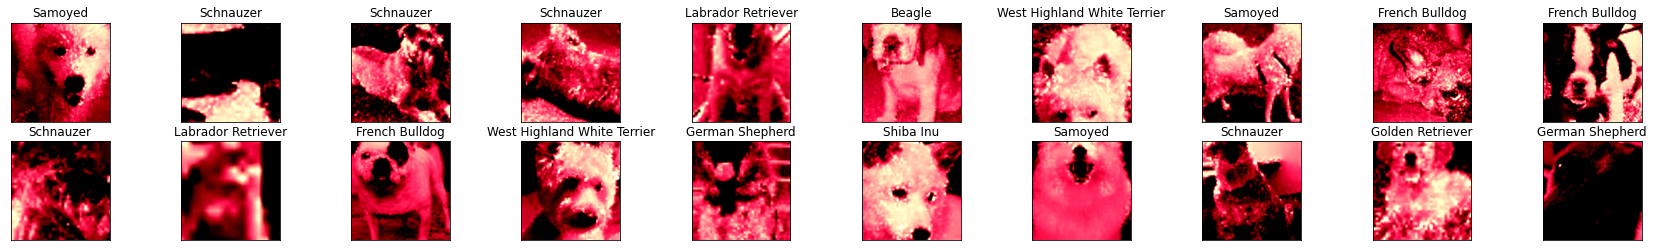

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

#3. Transfer Learning

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features

#4. Classification Model

In [ ]:
 class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6,  4069)
        self.fc2 = nn.Linear(4069,  1000)
        self.fc3 = nn.Linear(1000, 11)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#5. Training Setup

In [ ]:
def evaluate(model, loader, criterion):

    total_loss = 0
    total_correct = 0
    total_epoch = 0
    i = 0

    for imgs, labels in iter(loader):
          
        i += 1     

        if use_cuda and torch.cuda.is_available():

          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(features(imgs))
        pred = output.max(1, keepdim=True)[1]
        loss = criterion(output, labels)
        
        total_correct += pred.eq(labels.view_as(pred)).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)

    err =  1 - (total_correct/ total_epoch)
    loss = total_loss / (i + 1)
    return err, loss

In [ ]:
def get_accuracy(model, loader):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        
        if use_cuda and torch.cuda.is_available():
          
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        output = model(features(imgs))
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit 

        correct += pred.eq(labels.view_as(pred)).sum().item()
        # print('correct: ', correct)
        total += imgs.shape[0]
        # print('incorrect: ', total - correct)
    return correct / total

In [ ]:
def train(model, train_loader, val_loader, batch_size=20, learning_rate = 0.001,  num_epochs=1):


  torch.manual_seed(1000)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, train_error, val_error, train_loss, val_loss = [], [], [], [], []

  # training

  n = 0 # the number of iterations

  start_time = time.time()

  for epoch in range(num_epochs):

      mini_b= 0
      mini_batch_correct = 0
      Mini_batch_total = 0
      
      for imgs, labels in iter(train_loader):       
          
      #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():

          imgs = imgs.cuda()
          labels = labels.cuda()
        
        out = model(features(imgs))             # forward pass
        loss = criterion(out, labels) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch

        pred = out.max(1, keepdim=True)[1]
        mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
        Mini_batch_total = imgs.shape[0]

        train_error.append(1 - (mini_batch_correct / Mini_batch_total))
        train_loss.append(loss.item())
        

        iters.append(n)
        val_err, val_los = evaluate(model, val_loader, criterion)
        val_error.append(val_err)  # compute validation accuracy
        val_loss.append(val_los)  # compute validation accuracy

        n += 1
        mini_b += 1

      print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


  end_time = time.time()
  # plotting
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.set_title("Error")
  ax1.plot(iters, train_error, label="Training")
  ax1.plot(iters, val_error, label="Validation") 
  ax1.set_xlabel("Iterations")
  ax1.set_ylabel("Error")
  ax1.legend(loc='best')

  ax2.set_title("Loss")
  ax2.plot(iters, train_loss, label="Training")
  ax2.plot(iters, val_loss, label="Validation")    
  ax2.set_xlabel("Iterations")
  ax2.set_ylabel("Loss")
  ax2.legend(loc='best')
  
  fig.show()


  train_error.append(1 - get_accuracy(model, train_loader))

  print("Final Training Error:   {}\tFinal Training Accuracy:   {}".format(train_error[-1],1 - train_error[-1]))
  print("Final Validation Error: {}\tFinal Validation Accuracy: {}".format(val_error[-1]  ,1 - val_error[-1]  ))
  print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

#6. Test Setup

In [ ]:
def get_test_accuracy(model, data):
    correct = 0
    total = 0

    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

    # model.eval() #*********#
    
    for imgs, labels in loader:
        
        if use_cuda and torch.cuda.is_available():
          
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        output = model(imgs)
        
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        
        image = images[0]
        # place the colour channel at the end, instead of at the beginning
        img = np.transpose(image, [1,2,0])
        # normalize pixel intensity values to [0, 1]
        img = img / 2 + 0.5
        plt.subplot(3, 5, 1)
        plt.axis('off')
        plt.imshow(img)
        
        correct += pred.eq(labels.view_as(pred)).sum().item()
        print("predict", output)
        total += imgs.shape[0]
    return correct / total

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_random_images(data_dir, num):

    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor()
                                        #  ,transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                         ])

    data = datasets.ImageFolder(data_dir, transform=data_transform)
    classes = data.classes
    # classes.remove('.ipynb_checkpoints')

    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    return loader

8. new custom net

In [3]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [4]:
large_net = LargeNet()

In [8]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [5]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [9]:
train_net(large_net, 64, 0.01, 5)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train err: 0.464, Train loss: 0.691125256061554 |Validation err: 0.441, Validation loss: 0.6836152374744415
Epoch 2: Train err: 0.425875, Train loss: 0.6783481931686401 |Validation err: 0.434, Validation loss: 0.6845360100269318
Epoch 3: Train err: 0.399125, Train loss: 0.6629785122871399 |Validation err: 0.3755, Validation loss: 0.6498318407684565
Epoch 4: Train err: 0.36875, Train loss: 0.645973249912262 |Validation err: 0.349, Validation loss: 0.63760288618505
Epoch 5: Train err: 0.352625, Train loss: 0.6314461812973022 |Validation err: 0.345, Validation loss: 0.6247814148664474
Finished Training
Total time elapsed: 22.32 seconds


In [10]:
model_path_small = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)

OSError: ignored

#7. Training

CUDA is available!  Training on GPU ...
Epoch 0 Finished.  Time per Epoch:  109.96 s 
Epoch 1 Finished.  Time per Epoch:  106.82 s 
Epoch 2 Finished.  Time per Epoch:  106.26 s 
Epoch 3 Finished.  Time per Epoch:  105.45 s 
Epoch 4 Finished.  Time per Epoch:  105.27 s 
Epoch 5 Finished.  Time per Epoch:  104.74 s 
Epoch 6 Finished.  Time per Epoch:  104.39 s 
Epoch 7 Finished.  Time per Epoch:  104.37 s 
Epoch 8 Finished.  Time per Epoch:  104.03 s 
Epoch 9 Finished.  Time per Epoch:  103.79 s 
Final Training Error:   0.0	Final Training Accuracy:   1.0
Final Validation Error: 0.39583333333333337	Final Validation Accuracy: 0.6041666666666666
Total time:   1037.91 s  Time per Epoch:  103.79 s 


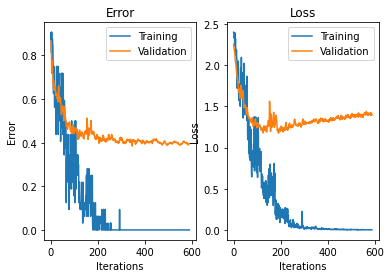

In [ ]:
use_cuda = True
features = alexnet.features
alex = AlexClassifier()

if use_cuda and torch.cuda.is_available():
  alex.cuda()
  features.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(alex, train_loader, val_loader, batch_size=32, num_epochs=10, learning_rate=0.0001)

#8. Test

In [ ]:
test_accuracy  = get_accuracy(alex, test_loader)

print('The test Accuracy is:',test_accuracy )

The test Accuracy is: 0.5775316455696202


In [ ]:
loader = get_random_images(test_dir, 10)
dataiter = iter(loader)
images, labels = dataiter.next()

if use_cuda and torch.cuda.is_available():

    images = images.cuda()
    labels = labels.cuda()

outputs = alex(features(images))

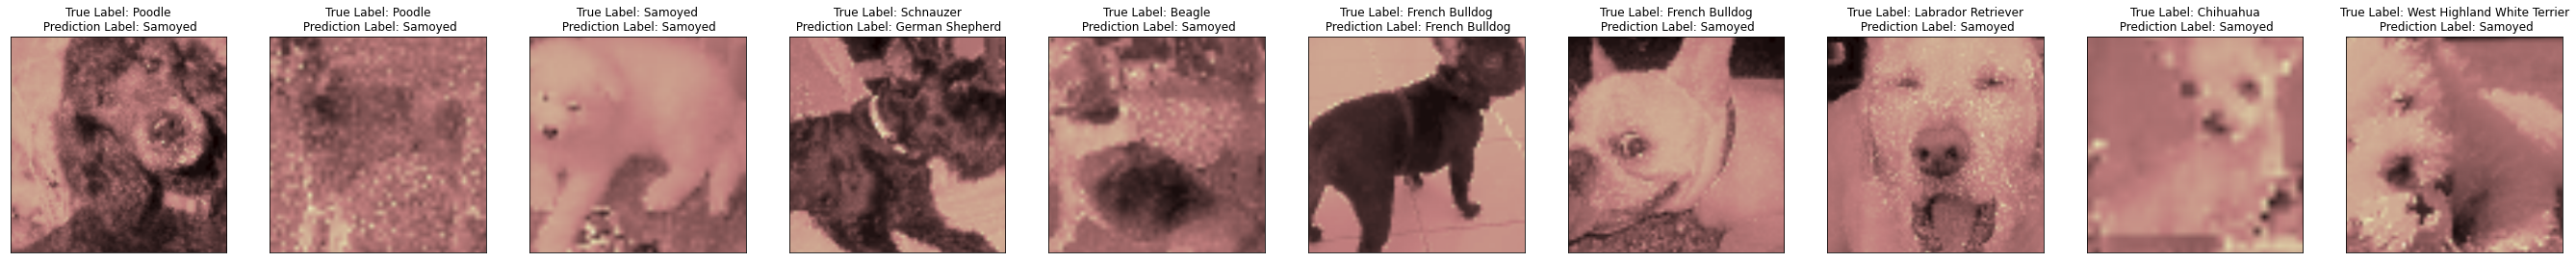

Accuracy:  2


In [ ]:
fig=plt.figure(figsize=(120,100))
accuracy = 0
for i in list(range(0, 10)):
    pred  = loader.dataset.classes[outputs[i].max(-1, keepdim=True)[1]]
    img =  images[i].cpu()
    lbl = loader.dataset.classes[labels[i]]

    if pred == lbl:
        accuracy += 1

    ax = fig.add_subplot(5, 50/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    title = 'True Label: ' + lbl + '\n Prediction Label: ' + pred
    ax.set_title(title)
    
plt.show()
print('Accuracy: ', accuracy)